# Analysis on Health Insurance Data

**Dataset:** US Premium Health Insurance Charges 

**Project Objective:** study and understand the risk underwriting in Health Insurance, the interplay of various attributes of the insured and to see how they affect the insurance premium.

## Exploring the Data


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cbook import boxplot_stats  
import statsmodels.api as sm
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score, cross_val_predict
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.tree import DecisionTreeRegressor
from sklearn import ensemble
import numpy as np

In [4]:
df = pd.read_csv('insurance (1).csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

**Age and BMI**

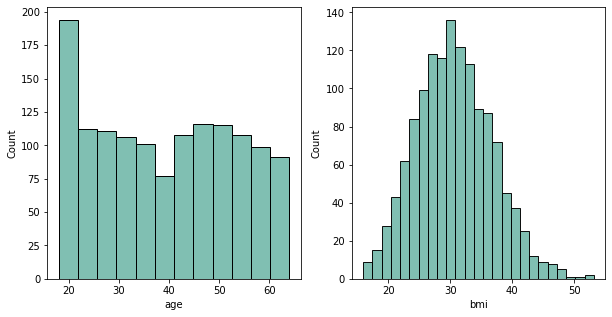

In [37]:

fig,axes=plt.subplots(1,2,figsize=(10,5))
sns.histplot( df['age'] , color="#5A9",ax=axes[0])
sns.histplot( df['bmi'] , color="#5A9",ax=axes[1])
plt.show()

In [16]:
#Converting age into age brackets
print("Minimum value for age : ", df['age'].min(),"\nMaximum value for age : ", df['age'].max())

#Age between min(age) to 40 years will fall under young
#Age between 41 to 58 years will fall under mid-age
#Age above 58 years will fall under old age

df.loc[(df['age'] >=18) & (df['age'] <= 40), 'age_group'] = 'young'
df.loc[(df['age'] >= 41) & (df['age'] <= 58), 'age_group'] = 'mid-age'
df.loc[df['age'] > 58, 'age_group'] = 'old'

Minimum value for age :  18 
Maximum value for age :  64


* BMI is distributed amlost normaly, and we can make age groups if needed.

In [17]:
#Finding the outlier values in the bmi column
outlier_list = boxplot_stats(df['bmi']).pop(0)['fliers'].tolist()
print(outlier_list)

#Finding the number of rows containing outliers
outlier_bmi_rows =df[df['bmi'].isin(outlier_list)].shape[0]
print("Number of rows contaning outliers in bmi : ", outlier_bmi_rows)

#Percentage of rows which are outliers
percent_bmi_outlier = (outlier_bmi_rows/df.shape[0])*100
print("Percentage of outliers in bmi columns : ", percent_bmi_outlier)

[49.06, 48.07, 47.52, 47.41, 50.38, 47.6, 52.58, 47.74, 53.13]
Number of rows contaning outliers in bmi :  9
Percentage of outliers in bmi columns :  0.672645739910314


Only 0.672 % are outliers, in bmi. So it is preferred to drop all such outliers.

In [18]:
#Removing outier from bmi column
df_clean = df[~df['bmi'].isin(outlier_list)]

**Categories: sex, children, smoker, region, and age group**

<AxesSubplot:xlabel='age_group', ylabel='count'>

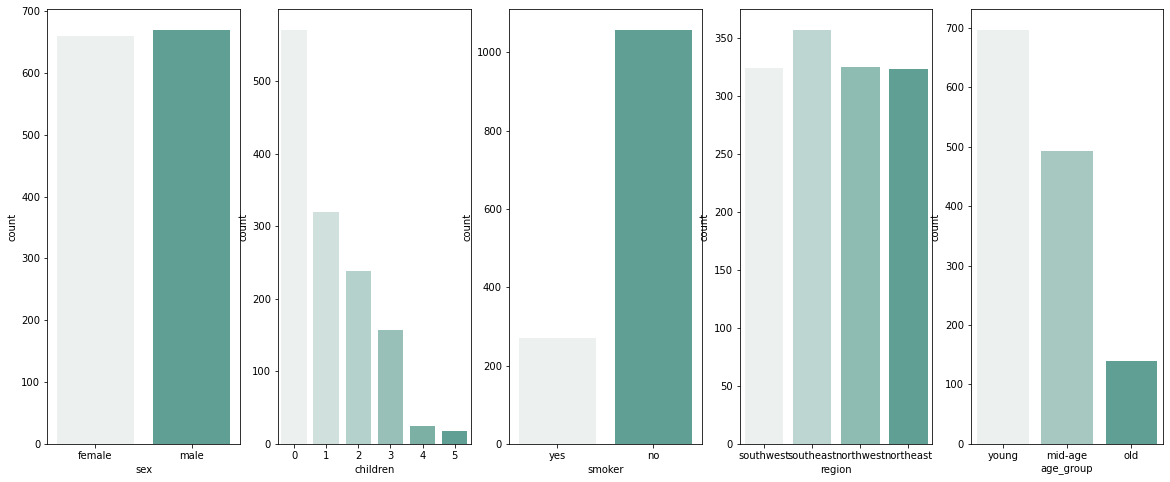

In [26]:
fig,axes=plt.subplots(1,5,figsize=(20,8))
sns.countplot(x = 'sex', data = df_clean, palette = "light:#5A9",ax=axes[0])
sns.countplot(x = 'children', data = df_clean, palette = "light:#5A9",ax=axes[1])
sns.countplot(x = 'smoker', data = df_clean, palette = "light:#5A9",ax=axes[2])
sns.countplot(x = 'region', data = df_clean, palette = "light:#5A9",ax=axes[3])
sns.countplot(x = 'age_group', data = df_clean, palette = "light:#5A9",ax=axes[4])

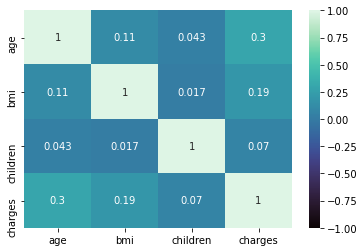

In [40]:
heatmap = sns.heatmap(df_clean.corr(), vmin=-1, vmax=1, annot=True, cmap="mako")

Age and BMI are more correlated with the Charges

### Multivariate Analysis

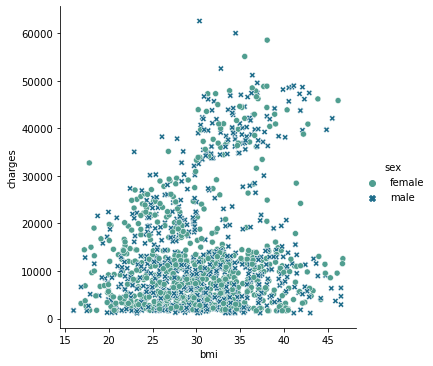

In [50]:
sns.relplot(x="bmi", y="charges",hue="sex", style = "sex", data=df_clean,palette = "crest");

<AxesSubplot:xlabel='smoker', ylabel='charges'>

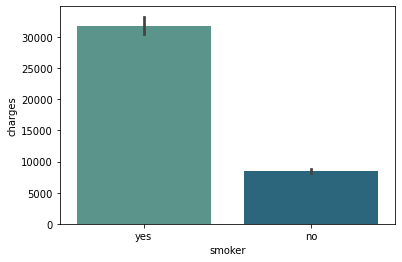

In [51]:
sns.barplot(x="smoker", y="charges", data=df_clean,palette = "crest")

## Modeling 

### Data Pre-Processing

In [53]:
categorical_var = ['sex','children','smoker','region','age_group'] #Number of categories in catagorical variables
for cat_value in categorical_var:
    print(cat_value," - ",df_clean[cat_value].unique())

sex  -  ['female' 'male']
children  -  [0 1 3 2 5 4]
smoker  -  ['yes' 'no']
region  -  ['southwest' 'southeast' 'northwest' 'northeast']
age_group  -  ['young' 'mid-age' 'old']


In [56]:
#Converting categorical values into dummies using one-hot encoding technique
df_processed = pd.get_dummies(df_clean, columns=['sex','children','smoker','region','age_group'], prefix=['sex','children','smoker','region','age_group'])
df_processed.drop(['age'],axis = 1,inplace=True)

In [57]:
df_processed.head()

,bmi,charges,sex_female,sex_male,children_0,children_1,children_2,children_3,children_4,children_5,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,age_group_mid-age,age_group_old,age_group_young
0,27.900,16884.92400,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1
1,33.770,1725.55230,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1
2,33.000,4449.46200,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,22.705,21984.47061,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1
4,28.880,3866.85520,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1


### Base-line Model Building

Base-line : linear regression model

In [58]:
X = df_processed.loc[:, df_processed.columns != 'charges']
y = df_processed['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     295.0
Date:                Fri, 21 Jan 2022   Prob (F-statistic):               0.00
Time:                        10:50:30   Log-Likelihood:                -13461.
No. Observations:                1329   AIC:                         2.695e+04
Df Residuals:                    1315   BIC:                         2.702e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              4565.8126    360.93

* model is able to explain 75.1% variation in the data
* for variables - children_1,children_2,children_3,children_5,region_northwest,region_southeast,region_southwest,age_group_mid-age the p-value > alpha which means that these variables are insignificant in predicting our target variable - charges


In [59]:
df_processed.columns

Index(['bmi', 'charges', 'sex_female', 'sex_male', 'children_0', 'children_1',
       'children_2', 'children_3', 'children_4', 'children_5', 'smoker_no',
       'smoker_yes', 'region_northeast', 'region_northwest',
       'region_southeast', 'region_southwest', 'age_group_mid-age',
       'age_group_old', 'age_group_young'],
      dtype='object')

In [60]:
df_vif = df_processed[['bmi', 'sex_female', 'sex_male', 'children_0', 'children_1','children_2', 'children_3', 'children_4', 'children_5', 'smoker_no','smoker_yes', 'region_northeast', 'region_northwest','region_southeast', 'region_southwest', 'age_group_mid-age','age_group_old', 'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) 
                          for i in range(len(df_vif.columns))] 
  
print(vif_data)

            attribute       VIF
0                 bmi  1.099784
1          sex_female       inf
2            sex_male       inf
3          children_0       inf
4          children_1       inf
5          children_2       inf
6          children_3       inf
7          children_4       inf
8          children_5       inf
9           smoker_no       inf
10         smoker_yes       inf
11   region_northeast       inf
12   region_northwest       inf
13   region_southeast       inf
14   region_southwest       inf
15  age_group_mid-age       inf
16      age_group_old       inf
17    age_group_young       inf


C:\Users\muafi\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [61]:
#Dropping children_1
X = df_processed[['bmi','sex_female', 'sex_male', 'children_0','children_2', 'children_3', 'children_4', 'children_5', 'smoker_no','smoker_yes', 'region_northeast', 'region_northwest','region_southeast', 'region_southwest', 'age_group_mid-age','age_group_old', 'age_group_young']]
y = df_processed['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     295.0
Date:                Fri, 21 Jan 2022   Prob (F-statistic):               0.00
Time:                        10:54:35   Log-Likelihood:                -13461.
No. Observations:                1329   AIC:                         2.695e+04
Df Residuals:                    1315   BIC:                         2.702e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              4566.9072    382.07

In [62]:
df_vif = df_processed[['bmi', 'sex_female', 'sex_male', 'children_0', 'children_2', 'children_3', 'children_4', 'children_5', 'smoker_no','smoker_yes', 'region_northeast', 'region_northwest','region_southeast', 'region_southwest', 'age_group_mid-age','age_group_old', 'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) 
                          for i in range(len(df_vif.columns))] 
  
print(vif_data)

            attribute       VIF
0                 bmi  1.099784
1          sex_female       inf
2            sex_male       inf
3          children_0  1.623418
4          children_2  1.436293
5          children_3  1.324000
6          children_4  1.060919
7          children_5  1.049968
8           smoker_no       inf
9          smoker_yes       inf
10   region_northeast       inf
11   region_northwest       inf
12   region_southeast       inf
13   region_southwest       inf
14  age_group_mid-age       inf
15      age_group_old       inf
16    age_group_young       inf


C:\Users\muafi\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [64]:
df_vif.corr(method ='pearson')

,bmi,sex_female,sex_male,children_0,children_2,children_3,children_4,children_5,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,age_group_mid-age,age_group_old,age_group_young
bmi,1.000000,-0.039958,0.039958,-0.012986,0.023607,0.009091,0.019978,-0.018461,0.002871,-0.002871,-0.136193,-0.128598,0.255863,0.000651,0.061722,0.070413,-0.102850
sex_female,-0.039958,1.000000,-1.000000,0.014784,-0.003984,-0.003964,-0.015470,-0.012050,0.079854,-0.079854,-0.000573,0.009961,-0.010263,0.001195,0.011029,0.010205,-0.016922
sex_male,0.039958,-1.000000,1.000000,-0.014784,0.003984,0.003964,0.015470,0.012050,-0.079854,0.079854,0.000573,-0.009961,0.010263,-0.001195,-0.011029,-0.010205,0.016922
children_0,-0.012986,0.014784,-0.014784,1.000000,-0.405377,-0.317665,-0.120175,-0.101699,0.009183,-0.009183,0.029145,-0.027001,0.002113,-0.004267,-0.122139,0.150396,0.025982
children_2,0.023607,-0.003984,0.003984,-0.405377,1.000000,-0.170947,-0.064671,-0.054728,-0.026637,0.026637,-0.035887,0.035606,0.009155,-0.009244,0.063833,-0.082676,-0.011082
children_3,0.009091,-0.003964,0.003964,-0.317665,-0.170947,1.000000,-0.050678,-0.042887,-0.040420,0.040420,0.004580,0.041256,-0.037731,-0.006925,0.027797,0.004414,-0.029592
children_4,0.019978,-0.015470,0.015470,-0.120175,-0.064671,-0.050678,1.000000,-0.016224,0.028837,-0.028837,0.011931,-0.001464,-0.021437,0.011676,-0.003140,-0.029224,0.020945
children_5,-0.018461,-0.012050,0.012050,-0.101699,-0.054728,-0.042887,-0.016224,1.000000,0.043146,-0.043146,-0.020864,-0.051521,0.017107,0.054758,-0.009126,-0.040047,0.033367
smoker_no,0.002871,0.079854,-0.079854,0.009183,-0.026637,-0.040420,0.028837,0.043146,1.000000,-1.000000,-0.004947,0.035940,-0.068270,0.039440,0.029108,-0.016209,-0.018222
smoker_yes,-0.002871,-0.079854,0.079854,-0.009183,0.026637,0.040420,-0.028837,-0.043146,-1.000000,1.000000,0.004947,-0.035940,0.068270,-0.039440,-0.029108,0.016209,0.018222


In [70]:
#Dropping sex_male
X = df_processed[['bmi','sex_female', 'children_0','children_2', 'children_3', 'children_4', 'children_5', 'smoker_no','smoker_yes', 'region_northeast', 'region_northwest','region_southeast', 'region_southwest', 'age_group_mid-age','age_group_old', 'age_group_young']]
y = df_processed['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     295.0
Date:                Fri, 21 Jan 2022   Prob (F-statistic):               0.00
Time:                        11:03:39   Log-Likelihood:                -13461.
No. Observations:                1329   AIC:                         2.695e+04
Df Residuals:                    1315   BIC:                         2.702e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              5647.7031    482.76

In [72]:
df_vif = df_processed[['bmi','sex_female', 'children_0','children_2', 'children_3', 'children_4', 'children_5', 'smoker_no','smoker_yes', 'region_northeast', 'region_northwest','region_southeast', 'region_southwest', 'age_group_mid-age','age_group_old', 'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) 
                          for i in range(len(df_vif.columns))] 
  
print(vif_data)

            attribute       VIF
0                 bmi  1.099784
1          sex_female  1.009197
2          children_0  1.623418
3          children_2  1.436293
4          children_3  1.324000
5          children_4  1.060919
6          children_5  1.049968
7           smoker_no       inf
8          smoker_yes       inf
9    region_northeast       inf
10   region_northwest       inf
11   region_southeast       inf
12   region_southwest       inf
13  age_group_mid-age       inf
14      age_group_old       inf
15    age_group_young       inf


In [73]:
#Dropping smoker_no
X = df_processed[['bmi','sex_female', 'children_0','children_2', 'children_3', 'children_4', 'children_5', 'smoker_yes', 'region_northeast', 'region_northwest','region_southeast', 'region_southwest', 'age_group_mid-age','age_group_old', 'age_group_young']]
y = df_processed['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     295.0
Date:                Fri, 21 Jan 2022   Prob (F-statistic):               0.00
Time:                        11:04:06   Log-Likelihood:                -13461.
No. Observations:                1329   AIC:                         2.695e+04
Df Residuals:                    1315   BIC:                         2.702e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                19.0403    636.55

In [75]:
df_vif = df_processed[['bmi','sex_female', 'children_0','children_2', 'children_3', 'children_4', 'children_5', 'smoker_yes', 'region_northeast', 'region_northwest','region_southeast', 'region_southwest', 'age_group_mid-age','age_group_old', 'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) 
                          for i in range(len(df_vif.columns))] 
  
print(vif_data)

            attribute       VIF
0                 bmi  1.099784
1          sex_female  1.009197
2          children_0  1.623418
3          children_2  1.436293
4          children_3  1.324000
5          children_4  1.060919
6          children_5  1.049968
7          smoker_yes  1.019222
8    region_northeast       inf
9    region_northwest       inf
10   region_southeast       inf
11   region_southwest       inf
12  age_group_mid-age       inf
13      age_group_old       inf
14    age_group_young       inf


C:\Users\muafi\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [76]:
df_vif.corr(method ='pearson')

,bmi,sex_female,children_0,children_2,children_3,children_4,children_5,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,age_group_mid-age,age_group_old,age_group_young
bmi,1.000000,-0.039958,-0.012986,0.023607,0.009091,0.019978,-0.018461,-0.002871,-0.136193,-0.128598,0.255863,0.000651,0.061722,0.070413,-0.102850
sex_female,-0.039958,1.000000,0.014784,-0.003984,-0.003964,-0.015470,-0.012050,-0.079854,-0.000573,0.009961,-0.010263,0.001195,0.011029,0.010205,-0.016922
children_0,-0.012986,0.014784,1.000000,-0.405377,-0.317665,-0.120175,-0.101699,-0.009183,0.029145,-0.027001,0.002113,-0.004267,-0.122139,0.150396,0.025982
children_2,0.023607,-0.003984,-0.405377,1.000000,-0.170947,-0.064671,-0.054728,0.026637,-0.035887,0.035606,0.009155,-0.009244,0.063833,-0.082676,-0.011082
children_3,0.009091,-0.003964,-0.317665,-0.170947,1.000000,-0.050678,-0.042887,0.040420,0.004580,0.041256,-0.037731,-0.006925,0.027797,0.004414,-0.029592
children_4,0.019978,-0.015470,-0.120175,-0.064671,-0.050678,1.000000,-0.016224,-0.028837,0.011931,-0.001464,-0.021437,0.011676,-0.003140,-0.029224,0.020945
children_5,-0.018461,-0.012050,-0.101699,-0.054728,-0.042887,-0.016224,1.000000,-0.043146,-0.020864,-0.051521,0.017107,0.054758,-0.009126,-0.040047,0.033367
smoker_yes,-0.002871,-0.079854,-0.009183,0.026637,0.040420,-0.028837,-0.043146,1.000000,0.004947,-0.035940,0.068270,-0.039440,-0.029108,0.016209,0.018222
region_northeast,-0.136193,-0.000573,0.029145,-0.035887,0.004580,0.011931,-0.020864,0.004947,1.000000,-0.322387,-0.343402,-0.321730,0.004290,-0.004486,-0.001401
region_northwest,-0.128598,0.009961,-0.027001,0.035606,0.041256,-0.001464,-0.051521,-0.035940,-0.322387,1.000000,-0.344807,-0.323046,-0.002032,-0.005673,0.005441


In [78]:
#Dropping sex_female
X = df_processed[['bmi','children_0','children_2', 'children_3', 'children_4', 'children_5', 'smoker_yes', 'region_northeast', 'region_northwest','region_southeast', 'region_southwest', 'age_group_mid-age','age_group_old', 'age_group_young']]
y = df_processed['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     319.8
Date:                Fri, 21 Jan 2022   Prob (F-statistic):               0.00
Time:                        11:05:32   Log-Likelihood:                -13461.
No. Observations:                1329   AIC:                         2.695e+04
Df Residuals:                    1316   BIC:                         2.701e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                44.3968    622.08

In [79]:
df_vif = df_processed[['bmi','children_0','children_2', 'children_3', 'children_4', 'children_5', 'smoker_yes', 'region_northeast', 'region_northwest','region_southeast', 'region_southwest', 'age_group_mid-age','age_group_old', 'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) 
                          for i in range(len(df_vif.columns))] 
  
print(vif_data)

            attribute       VIF
0                 bmi  1.097820
1          children_0  1.623280
2          children_2  1.436286
3          children_3  1.323996
4          children_4  1.060698
5          children_5  1.049756
6          smoker_yes  1.012572
7    region_northeast       inf
8    region_northwest       inf
9    region_southeast       inf
10   region_southwest       inf
11  age_group_mid-age       inf
12      age_group_old       inf
13    age_group_young       inf


C:\Users\muafi\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [80]:
#Dropping region_northwest
X = df_processed[['bmi','children_0','children_2', 'children_3', 'children_4', 'children_5', 'smoker_yes', 'region_northeast', 'region_southeast', 'region_southwest', 'age_group_mid-age','age_group_old', 'age_group_young']]
y = df_processed['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     319.8
Date:                Fri, 21 Jan 2022   Prob (F-statistic):               0.00
Time:                        11:06:53   Log-Likelihood:                -13461.
No. Observations:                1329   AIC:                         2.695e+04
Df Residuals:                    1316   BIC:                         2.701e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               226.1202    746.16

In [81]:
df_vif =df_processed[['bmi','children_0','children_2', 'children_3', 'children_4', 'children_5', 'smoker_yes', 'region_northeast', 'region_southeast', 'region_southwest', 'age_group_mid-age','age_group_old', 'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) 
                          for i in range(len(df_vif.columns))] 
  
print(vif_data)

            attribute        VIF
0                 bmi   1.097820
1          children_0   1.623280
2          children_2   1.436286
3          children_3   1.323996
4          children_4   1.060698
5          children_5   1.049756
6          smoker_yes   1.012572
7    region_northeast   1.515483
8    region_southeast   1.643003
9    region_southwest   1.530183
10  age_group_mid-age  13.447775
11      age_group_old   4.809862
12    age_group_young  17.769851


In [82]:
#Dropping age_group_mid-age
X = df_processed[['bmi','children_0','children_2', 'children_3', 'children_4', 'children_5', 'smoker_yes', 'region_northeast', 'region_southeast', 'region_southwest', 'age_group_old', 'age_group_young']]
y = df_processed['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     319.8
Date:                Fri, 21 Jan 2022   Prob (F-statistic):               0.00
Time:                        11:08:03   Log-Likelihood:                -13461.
No. Observations:                1329   AIC:                         2.695e+04
Df Residuals:                    1316   BIC:                         2.701e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              432.0653   1005.835  

In [83]:
df_vif = df_processed[['bmi','children_0','children_2', 'children_3', 'children_4', 'children_5', 'smoker_yes', 'region_northeast', 'region_southeast', 'region_southwest', 'age_group_old', 'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) 
                          for i in range(len(df_vif.columns))] 
  
print(vif_data)

           attribute       VIF
0                bmi  7.499317
1         children_0  2.676311
2         children_2  1.675961
3         children_3  1.452813
4         children_4  1.076977
5         children_5  1.057367
6         smoker_yes  1.264397
7   region_northeast  1.883785
8   region_southeast  2.244260
9   region_southwest  1.965415
10     age_group_old  1.320875
11   age_group_young  2.276242


In [84]:
#Dropping children_5
X = df_processed[['bmi','children_0','children_2', 'children_3', 'children_4', 'smoker_yes', 'region_northeast', 'region_southeast', 'region_southwest', 'age_group_old', 'age_group_young']]
y =df_processed['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     349.0
Date:                Fri, 21 Jan 2022   Prob (F-statistic):               0.00
Time:                        11:09:39   Log-Likelihood:                -13461.
No. Observations:                1329   AIC:                         2.695e+04
Df Residuals:                    1317   BIC:                         2.701e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              473.3410   1002.335  

In [85]:
df_vif = df_processed[['bmi','children_0','children_2', 'children_3', 'children_4', 'smoker_yes', 'region_northeast', 'region_southeast', 'region_southwest', 'age_group_old', 'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) 
                          for i in range(len(df_vif.columns))] 
  
print(vif_data)

           attribute       VIF
0                bmi  7.429867
1         children_0  2.602154
2         children_2  1.645952
3         children_3  1.433957
4         children_4  1.073344
5         smoker_yes  1.263044
6   region_northeast  1.881015
7   region_southeast  2.239522
8   region_southwest  1.953433
9      age_group_old  1.320862
10   age_group_young  2.270042


In [86]:
#Dropping region_northeast
X = df_processed[['bmi','children_0','children_2', 'children_3', 'children_4', 'smoker_yes',  'region_southeast', 'region_southwest', 'age_group_old', 'age_group_young']]
y = df_processed['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     383.9
Date:                Fri, 21 Jan 2022   Prob (F-statistic):               0.00
Time:                        11:10:55   Log-Likelihood:                -13461.
No. Observations:                1329   AIC:                         2.694e+04
Df Residuals:                    1318   BIC:                         2.700e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              695.1766    971.644  

In [87]:
df_vif = df_processed[['bmi','children_0','children_2', 'children_3', 'children_4', 'smoker_yes',  'region_southeast', 'region_southwest', 'age_group_old', 'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) 
                          for i in range(len(df_vif.columns))] 
  
print(vif_data)

          attribute       VIF
0               bmi  6.011912
1        children_0  2.589894
2        children_2  1.645803
3        children_3  1.433506
4        children_4  1.072911
5        smoker_yes  1.260157
6  region_southeast  1.672064
7  region_southwest  1.510284
8     age_group_old  1.320731
9   age_group_young  2.261170


In [88]:
#Dropping children_4
X = df_processed[['bmi','children_0','children_2', 'children_3', 'smoker_yes',  'region_southeast', 'region_southwest', 'age_group_old', 'age_group_young']]
y = df_processed['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     424.7
Date:                Fri, 21 Jan 2022   Prob (F-statistic):               0.00
Time:                        11:11:59   Log-Likelihood:                -13464.
No. Observations:                1329   AIC:                         2.695e+04
Df Residuals:                    1319   BIC:                         2.700e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              826.7383    971.429  

In [89]:
df_vif = df_processed[['bmi','children_0','children_2', 'children_3', 'smoker_yes',  'region_southeast', 'region_southwest', 'age_group_old', 'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) 
                          for i in range(len(df_vif.columns))] 
  
print(vif_data)

          attribute       VIF
0               bmi  5.781882
1        children_0  2.488388
2        children_2  1.603427
3        children_3  1.405484
4        smoker_yes  1.259944
5  region_southeast  1.669594
6  region_southwest  1.510283
7     age_group_old  1.320706
8   age_group_young  2.257210


In [90]:
#Dropping children_3
X = df_processed[['bmi','children_0','children_2', 'smoker_yes',  'region_southeast', 'region_southwest', 'age_group_old', 'age_group_young']]
y = df_processed['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     477.8
Date:                Fri, 21 Jan 2022   Prob (F-statistic):               0.00
Time:                        11:13:14   Log-Likelihood:                -13464.
No. Observations:                1329   AIC:                         2.695e+04
Df Residuals:                    1320   BIC:                         2.699e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              947.4608    958.120  

In [91]:
df_vif = df_processed[['bmi','children_0','children_2', 'smoker_yes',  'region_southeast', 'region_southwest', 'age_group_old', 'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) 
                          for i in range(len(df_vif.columns))] 
  
print(vif_data)

          attribute       VIF
0               bmi  4.874029
1        children_0  2.071018
2        children_2  1.432274
3        smoker_yes  1.254084
4  region_southeast  1.660974
5  region_southwest  1.509681
6     age_group_old  1.316678
7   age_group_young  2.252979


In [92]:
#Dropping children_2
X = df_processed[['bmi','children_0', 'smoker_yes',  'region_southeast', 'region_southwest', 'age_group_old', 'age_group_young']]
y = df_processed['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     544.7
Date:                Fri, 21 Jan 2022   Prob (F-statistic):               0.00
Time:                        11:15:24   Log-Likelihood:                -13466.
No. Observations:                1329   AIC:                         2.695e+04
Df Residuals:                    1321   BIC:                         2.699e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1186.4016    949.616  

In [93]:
df_vif = df_processed[['bmi','children_0', 'smoker_yes',  'region_southeast', 'region_southwest', 'age_group_old', 'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) 
                          for i in range(len(df_vif.columns))] 
  
print(vif_data)

          attribute       VIF
0               bmi  4.201606
1        children_0  1.770557
2        smoker_yes  1.252199
3  region_southeast  1.660546
4  region_southwest  1.509675
5     age_group_old  1.316294
6   age_group_young  2.250656


* This is the final baseline model
* Features considered are: bmi , children_0,smoker_yes, region_southeast, region_southwest, age_group_old, age_group_young
* Final R squared obtained for base model - 74.1%

### Advanced Model: Decision Tree Regressor

In [94]:
X = df_processed.loc[:, df_processed.columns != 'charges']
y = df_processed['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

dtr = DecisionTreeRegressor(max_depth=4,
                           min_samples_split=5,
                           max_leaf_nodes=10)

dtr.fit(X_train,y_train)
print("R-Squared on train dataset={}".format(dtr.score(X_train,y_train)))

dtr.fit(X_test,y_test)   
print("R-Squaredon test dataset={}".format(dtr.score(X_test,y_test)))

R-Squared on train dataset=0.8651948630371276
R-Squaredon test dataset=0.8408872077196387


**Hyper-parameter tuning using Grid Search**

In [95]:

param_grid = {"criterion": ["mse", "mae"],
              "min_samples_split": [2, 5, 10, 15,20, 40],
              "max_depth": [2, 4, 6, 8],
              "max_leaf_nodes": [2, 5, 10, 20, 100],
              "min_samples_leaf": [2, 5, 10, 20, 100],
              }

grid_cv_dtr = GridSearchCV(dtr, param_grid, cv=5)

grid_cv_dtr.fit(X,y)

print("R-Squared::{}".format(grid_cv_dtr.best_score_))
print("Best Hyperparameters::\n{}".format(grid_cv_dtr.best_params_))

R-Squared::0.8464037958681339
Best Hyperparameters::
{'criterion': 'mse', 'max_depth': 4, 'max_leaf_nodes': 20, 'min_samples_leaf': 10, 'min_samples_split': 2}


### Advanced Model : Gradient Boosting

In [96]:
X = df_processed.loc[:, health_ins_df_processed.columns != 'charges']
y = df_processed['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

p_tuning_1 = {'learning_rate':[0.020,0.015,0.01], 'n_estimators':[250,500,750]}

tuning_1 = GridSearchCV(estimator =ensemble.GradientBoostingRegressor(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,loss = 'ls',criterion = 'mse'), 
            param_grid = p_tuning_1, n_jobs=4,cv=5,verbose = True)
tuning_1.fit(X_train,y_train)
tuning_1.cv_results_, tuning_1.best_score_, tuning_1.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


({'mean_fit_time': array([0.39888859, 0.78924499, 1.10738273, 0.35319395, 0.6995542 ,
         1.18590999, 0.37333574, 0.70969987, 0.96621003]),
  'std_fit_time': array([0.00629696, 0.00852195, 0.02818193, 0.01978742, 0.01123528,
         0.0349045 , 0.02057867, 0.01022165, 0.09328862]),
  'mean_score_time': array([0.05024586, 0.01070399, 0.01096849, 0.00624914, 0.00763965,
         0.01021752, 0.00611992, 0.0069818 , 0.00671477]),
  'std_score_time': array([0.02276912, 0.00343745, 0.00623198, 0.0076536 , 0.00699106,
         0.00281903, 0.00513711, 0.0006306 , 0.00599555]),
  'param_learning_rate': masked_array(data=[0.02, 0.02, 0.02, 0.015, 0.015, 0.015, 0.01, 0.01,
                     0.01],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_n_estimators': masked_array(data=[250, 500, 750, 250, 500, 750, 250, 500, 750],
               mask=[False, False, False, Fals

In [97]:
p_tuning_2 = {'max_depth':[2,4,6,8], 'min_samples_split':[2,5,8,10],'min_samples_leaf':[1,2,5]}

tuning_2 = GridSearchCV(estimator =ensemble.GradientBoostingRegressor(learning_rate=0.015, n_estimators=250, subsample=1,loss = 'ls',criterion = 'mse'), 
            param_grid = p_tuning_2, n_jobs=4,cv=5,verbose = True)
tuning_2.fit(X_train,y_train)
tuning_2.cv_results_, tuning_2.best_score_, tuning_2.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


({'mean_fit_time': array([0.25101523, 0.27762313, 0.26382565, 0.28104982, 0.26728468,
         0.25411906, 0.23856082, 0.24055634, 0.26588826, 0.25850759,
         0.24294934, 0.23317294, 0.37878194, 0.47513018, 0.52639093,
         0.48769302, 0.40492001, 0.42346601, 0.48629255, 0.52937765,
         0.36781712, 0.35664454, 0.35504789, 0.38258657, 0.63011327,
         0.51023369, 0.476125  , 0.47073884, 0.50664282, 0.52698836,
         0.50863752, 0.53796029, 0.53356934, 0.46016803, 0.45797334,
         0.45877242, 0.61894188, 0.58842497, 0.571071  , 0.56129742,
         0.58244042, 0.58554044, 0.55320325, 0.55924196, 0.5342485 ,
         0.54362078, 0.54362173, 0.53958554]),
  'std_fit_time': array([0.01165123, 0.01232173, 0.02918492, 0.02421335, 0.01181703,
         0.00668682, 0.00927913, 0.00788894, 0.00963897, 0.00536636,
         0.00786857, 0.00270275, 0.0288815 , 0.03793675, 0.00910515,
         0.02447914, 0.0204352 , 0.02352212, 0.02330315, 0.02427644,
         0.01281053, 0.

In [98]:
f_model = ensemble.GradientBoostingRegressor(learning_rate=0.015, n_estimators=250, max_depth=4,min_samples_leaf=5,min_samples_split=10,subsample=1,loss = 'ls',criterion = 'mse')
f_model.fit(X_train, y_train)
print("Accuracy score (training): {0:.3f}".format(f_model.score(X_train, y_train)))

f_model.fit(X_test, y_test)
print("Accuracy score (test): {0:.3f}".format(f_model.score(X_test, y_test)))

Accuracy score (training): 0.875
Accuracy score (test): 0.898


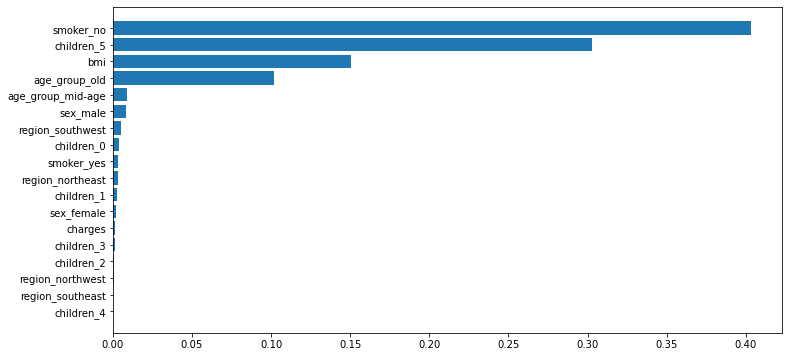

In [99]:
feature_importance = f_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(health_ins_df_processed.columns)[sorted_idx])
plt.show()